In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
def rca_create_clutter_map(filename):
    '''Creates a clutter map (precip-free day) to be used for the RCA calculation for PPIs'''
    radar = pyart.aux_io.read_gamic(filename, file_field_names=True) 
    #radar = pyart.io.cfradial.read_cfradial(filename)
    date_time = radar.time['units'].replace('seconds since ', '')
    
    # Constrain range between 1 - 5 km
    r_start_idx = np.where(radar.range['data'] < 1000.)[0][-1]+1
    r_start_idx = 0
    r_stop_idx = np.where(radar.range['data'] > 10000.)[0][0]
    
    # Using lowest elevation angle of PPI (0.5 deg)
    sweep_start_idx = radar.sweep_start_ray_index['data'][0]
    sweep_stop_idx = radar.sweep_end_ray_index['data'][0]+1
    
    # Get variables (only the rays/gates needed)
    zh = radar.fields['Zh']['data'][sweep_start_idx:sweep_stop_idx,r_start_idx:r_stop_idx]
    zv = radar.fields['Zv']['data'][sweep_start_idx:sweep_stop_idx,r_start_idx:r_stop_idx]
    r = radar.range['data'][r_start_idx:r_stop_idx]
    theta = radar.azimuth['data'][sweep_start_idx:sweep_stop_idx]
    
    # Eliminate duplicate azimuths to maintain a total # of azimuths of 360
    if len(theta) > 360:
        diff = len(theta) - 360
        zh = np.delete(zh,-diff,axis=0)
        zv = np.delete(zh,-diff,axis=0)
        theta = np.delete(theta,-diff)
        
    # Arrange/sort azimuths to span 0 to 360 deg. from index 0 to 359
    sorted_idx = np.argsort(theta)
    zh = zh[sorted_idx,:]
    zv = zv[sorted_idx,:]
    theta = theta[sorted_idx]
    
    # Create a fixed polar grid/array (FPG; 1 deg x 1 km) and create mask to flag clutter
    r_grid = np.array((0,1,2,3,4,5,6,7,8,9,10))*1000.
    theta_grid = theta
    r_matrix, theta_matrix = np.meshgrid(r_grid,theta_grid)
    clutter_flag = np.zeros((r_matrix.shape))
    clutter_flag_v = np.zeros((r_matrix.shape))
    
    # Set reflectivity threshold 55 dBZ
    # Flag PPI pixels in FPG box that exceed threshold
    z_thresh = 45.
    zv_thresh = 45.
    
    # H POLARIZATION
    # Create an empty array to fill with Z from the clutter area reflectivity grid boxes (CAR)
    zh_car = np.empty((zh.shape))
    zh_car[:,:] = np.nan

    for i in range(0,len(theta_matrix[:,0])):
        for j in range(0,len(r_matrix[0,:])):
            if j == 0:
                clutter_flag[:,0] = np.nan
            else:
                if np.logical_or(zh[i,j*10-10] >= z_thresh, zh[i,j*10-9] >= z_thresh):
                    clutter_flag[i,j] = 1
                    zh_car[i,j*10-10:j*10-1] = zh[i,j*10-10:j*10-1]
                elif np.logical_or(zh[i,j*10-8] >= z_thresh, zh[i,j*10-7] >= z_thresh):
                    clutter_flag[i,j] = 1
                    zh_car[i,j*10-10:j*10-1] = zh[i,j*10-10:j*10-1]
                elif np.logical_or(zh[i,j*10-6] >= z_thresh, zh[i,j*10-5] >= z_thresh):
                    clutter_flag[i,j] = 1
                    zh_car[i,j*10-10:j*10-1] = zh[i,j*10-10:j*10-1]
                elif np.logical_or(zh[i,j*10-4] >= z_thresh, zh[i,j*10-3] >= z_thresh):
                    clutter_flag[i,j] = 1
                    zh_car[i,j*10-10:j*10-1] = zh[i,j*10-10:j*10-1]
                elif np.logical_or(zh[i,j*10-2] >= z_thresh, zh[i,j*10-1] >= z_thresh):
                    clutter_flag[i,j] = 1
                    zh_car[i,j*10-10:j*10-1] = zh[i,j*10-10:j*10-1]
                else:
                    clutter_flag[i,j] = 0
    
    # V POLARIZATION
    # Create an empty array to fill with Z from the clutter area reflectivity grid boxes (CAR)
    zv_car = np.empty((zv.shape))
    zv_car[:,:] = np.nan

    for i in range(0,len(theta_matrix[:,0])):
        for j in range(0,len(r_matrix[0,:])):
            if j == 0:
                clutter_flag_v[:,0] = np.nan
            else:
                if np.logical_or(zv[i,j*10-10] >= zv_thresh, zv[i,j*10-9] >= zv_thresh):
                    clutter_flag_v[i,j] = 1
                    zv_car[i,j*10-10:j*10-1] = zv[i,j*10-10:j*10-1]
                elif np.logical_or(zv[i,j*10-8] >= zv_thresh, zv[i,j*10-7] >= zv_thresh):
                    clutter_flag_v[i,j] = 1
                    zv_car[i,j*10-10:j*10-1] = zv[i,j*10-10:j*10-1]
                elif np.logical_or(zv[i,j*10-6] >= zv_thresh, zv[i,j*10-5] >= zv_thresh):
                    clutter_flag_v[i,j] = 1
                    zv_car[i,j*10-10:j*10-1] = zv[i,j*10-10:j*10-1]
                elif np.logical_or(zv[i,j*10-4] >= zv_thresh, zv[i,j*10-3] >= zv_thresh):
                    clutter_flag_v[i,j] = 1
                    zv_car[i,j*10-10:j*10-1] = zv[i,j*10-10:j*10-1]
                elif np.logical_or(zv[i,j*10-2] >= zv_thresh, zv[i,j*10-1] >= zv_thresh):
                    clutter_flag_v[i,j] = 1
                    zv_car[i,j*10-10:j*10-1] = zv[i,j*10-10:j*10-1]
                else:
                    clutter_flag_v[i,j] = 0
    
    del radar
    return clutter_flag, clutter_flag_v, r_matrix, theta_matrix, zh, zv, zh_car, zv_car, date_time

In [5]:
# Run this function on a bunch of files (try data from one day)
import os
import glob
import scipy.stats as stats
from scipy.stats import norm 

clutter_flag = []
clutter_flag_v = []
theta = []
r = []
zh = []
zhCAR = []
zv = []
zvCAR = []
dt = []

for f in glob.glob(os.path.join('/home/hunzinger/data/ppi/', 'corcsaprM1*.20181108.*cor-ppi*.h5')):
    print(f)
    ClutterFlag, ClutterFlagV, R, Theta, ZH, ZV, ZHCAR, ZVCAR, DateTime = rca_create_clutter_map(f)
    
    # Put all PPI times into a list
    clutter_flag.append(ClutterFlag)
    clutter_flag_v.append(ClutterFlagV)
    r.append(R)
    theta.append(Theta)
    zh.append(ZH)
    zhCAR.append(ZHCAR)
    zv.append(ZV)
    zvCAR.append(ZVCAR)
    dt.append(DateTime)


/home/hunzinger/data/ppi/corcsaprM1.00.20181108.231001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181108214503_00.h5
/home/hunzinger/data/ppi/corcsaprM1.00.20181108.151001.raw.cor-ppi-cacti-15tilt_CSAPR2_20181108140003_00.h5


IndexError: index 359 is out of bounds for axis 0 with size 359

(76, 360, 6)
(360, 6)


/home/hunzinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less_equal
  """


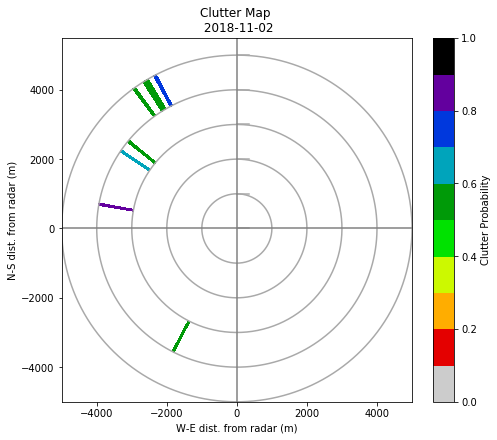

In [5]:
clutter_flag = np.asarray(clutter_flag)
print(clutter_flag.shape)
PCT_on = np.sum(clutter_flag,axis=0)/len(clutter_flag[:,0,0])
# Mask values less than 0.5
mask_u50 = np.where(PCT_on <= 0.5)
PCT_on_50 = np.copy(PCT_on)
PCT_on_50[mask_u50] = np.nan
print(PCT_on_50.shape)

# Plot clutter map
from matplotlib.colors import BoundaryNorm
# Convert to cartesian coords to plot
x = (r[0]*np.sin(theta[0]*np.pi/180.))
y = (r[0]*np.cos(theta[0]*np.pi/180.))
#levels = np.arange(6)/10+0.5
levels = np.arange(11)/10
# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('nipy_spectral_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax1 = plt.subplots(figsize=[6.8,6],constrained_layout=True)
ax1.plot(x,y,(x**2+y**2)**(0.5),color='darkgrey')
ax1.axvline(0,-5000,5000,color='grey')
ax1.axhline(0,-5000,5000,color='grey')
im = ax1.pcolormesh(x, y, PCT_on_50, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax1)
cbar.ax.set_ylabel('Clutter Probability')
ax1.set_title('Clutter Map \n 2018-11-02')
ax1.set_xlabel('W-E dist. from radar (m)')
ax1.set_ylabel('N-S dist. from radar (m)')

plt.show()

# V POLARIZATION
clutter_flag_v = np.asarray(clutter_flag_v)
print(clutter_flag_v.shape)
vPCT_on = np.sum(clutter_flag_v,axis=0)/len(clutter_flag_v[:,0,0])
# Mask values less than 0.5
mask_u50 = np.where(vPCT_on <= 0.5)
vPCT_on_50 = np.copy(vPCT_on)
vPCT_on_50[mask_u50] = np.nan
print(vPCT_on_50.shape)

# Plot clutter map
from matplotlib.colors import BoundaryNorm
# Convert to cartesian coords to plot
x = (r[0]*np.sin(theta[0]*np.pi/180.))
y = (r[0]*np.cos(theta[0]*np.pi/180.))
#levels = np.arange(6)/10+0.5
levels = np.arange(11)/10
# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('nipy_spectral_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax1 = plt.subplots(figsize=[6.8,6],constrained_layout=True)
ax1.plot(x,y,(x**2+y**2)**(0.5),color='darkgrey')
ax1.axvline(0,-10000,10000,color='grey')
ax1.axhline(0,-10000,10000,color='grey')
im = ax1.pcolormesh(x, y, vPCT_on_50, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax1)
cbar.ax.set_ylabel('Clutter Probability')
ax1.set_title('Clutter Map (V pol.) \n 2018-11-02')
ax1.set_xlabel('W-E dist. from radar (m)')
ax1.set_ylabel('N-S dist. from radar (m)')

plt.show()

In [6]:
from netCDF4 import Dataset
dataset = Dataset('/home/hunzinger/data/rca_cluttermap_20181108.nc',
                  'w',format='NETCDF4_CLASSIC')
azi = dataset.createDimension('azi', 360)
rang = dataset.createDimension('rang', 11)
value = dataset.createDimension('value',1)

PCT_ON_50 = dataset.createVariable('Flagged clutter grid gates', np.float64, ('azi','rang'))
vPCT_ON_50 = dataset.createVariable('Flagged clutter grid gates (V)', np.float64, ('azi','rang'))

PCT_ON_50[:,:] = PCT_on_50
vPCT_ON_50[:,:] = vPCT_on_50

dataset.close()